# RSI_Hedge_v1.1

## Setup

### Packages

In [1]:
from utils.packages import *
#from utils.tools import *

### Inputs and Parameters

#### Read Yaml files

In [2]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)
    
temp_file = 'config/currencies.yaml'
with open(temp_file) as temp_file:
    currs = yaml.load(temp_file)        

#### Yaml Variables

In [3]:
access_token = config['oanda_demo_hedge']['token']
accountID = config['oanda_demo_hedge']['account_id']
data = {}
data['instrument'] = "EUR_USD"
data['pip_size'] = currs['currs'][data['instrument']]['pip_size']

In [4]:
params = {'instruments': data['instrument']}
api = API(access_token = access_token)
request_data = pricing.PricingStream(accountID=accountID, params=params)
response_stream = api.request(request_data)

In [5]:
data['iter_max'] = 30
data['rsi_len'] = 14
data['rsi_ready_flag'] = False
data['tick_list'] = collections.deque([])
data['UpPrice'] = collections.deque([])
data['DownPrice'] = collections.deque([])
data['AvgGain'] = collections.deque([])
data['AvgLoss'] = collections.deque([])
data['RS'] = collections.deque([])
data['RSI'] = collections.deque([])

In [6]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Get timestamp of the price and segregate it
def get_date_time(resp):
    global data
    time_stamp = resp['time']
    data['date_val'], full_time = time_stamp.split(sep = 'T')
    data['time_val'], data['time_fraction'] = full_time.split(sep = '.')
    return()
#=============================================================================================================================================================================


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Get bid and ask prices
def get_prices(resp):    
    global data
    data['bid_price'] = float(resp['bids'][0]['price'])    
    data['ask_price'] = float(resp['asks'][0]['price'])
    data['spread'] = data['ask_price'] - data['bid_price']
    data['tick_price'] = (data['ask_price'] + data['bid_price']) / 2
    return()
#=============================================================================================================================================================================


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def before_rsi_len():
    global data
    data['tick_list'].append(data['tick_price'])

    if len(data['tick_list']) == 1:
        data['UpPrice'].append(0)
        data['DownPrice'].append(0)
        data['AvgGain'].append(0)
        data['AvgLoss'].append(0)
        data['RS'].append(0)
        data['RSI'].append(0)
    elif len(data['tick_list']) > 1:
        old_price = data['tick_list'][len(data['tick_list'])-2]
        new_price = data['tick_price']
        if new_price > old_price:
            data['UpPrice'].append(new_price - old_price)
            data['DownPrice'].append(0)
            data['AvgGain'].append(np.mean(data['UpPrice']))
            data['AvgLoss'].append(np.mean(data['DownPrice']))
            data['RS'].append(data['AvgGain'][len(data['AvgGain'])-1]/data['AvgLoss'][len(data['AvgLoss'])-1])
            data['RSI'].append(100 - (100/(1+data['RS'][len(data['RS'])-1])))
        elif old_price > new_price:
            data['UpPrice'].append(0)
            data['DownPrice'].append(old_price - new_price)
            data['AvgGain'].append(np.mean(data['UpPrice']))
            data['AvgLoss'].append(np.mean(data['DownPrice']))
            data['RS'].append(data['AvgGain'][len(data['AvgGain'])-1]/data['AvgLoss'][len(data['AvgLoss'])-1])
            data['RSI'].append(100 - (100/(1+data['RS'][len(data['RS'])-1])))
    return()
#=============================================================================================================================================================================    


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def after_rsi_len():
    global data
    data['UpPrice'].popleft()
    data['DownPrice'].popleft()
    data['AvgGain'].popleft()
    data['AvgLoss'].popleft()
    data['RS'].popleft()
    data['RSI'].popleft()
    data['tick_list'].popleft()
    data['tick_list'].append(data['tick_price'])

    old_price = data['tick_list'][len(data['tick_list'])-2]
    new_price = data['tick_price']
    if new_price > old_price:
        data['UpPrice'].append(new_price - old_price)
        data['DownPrice'].append(0)
        data['AvgGain'].append(np.mean(data['UpPrice']))
        data['AvgLoss'].append(np.mean(data['DownPrice']))
        data['RS'].append(data['AvgGain'][len(data['AvgGain'])-1]/data['AvgLoss'][len(data['AvgLoss'])-1])
        data['RSI'].append(100 - (100/(1+data['RS'][len(data['RS'])-1])))
    elif old_price > new_price:
        data['UpPrice'].append(0)
        data['DownPrice'].append(old_price - new_price)
        data['AvgGain'].append(np.mean(data['UpPrice']))
        data['AvgLoss'].append(np.mean(data['DownPrice']))
        data['RS'].append(data['AvgGain'][len(data['AvgGain'])-1]/data['AvgLoss'][len(data['AvgLoss'])-1])
        data['RSI'].append(100 - (100/(1+data['RS'][len(data['RS'])-1])))

    return()
#=============================================================================================================================================================================    

In [7]:
temp=[]
temp1=[]

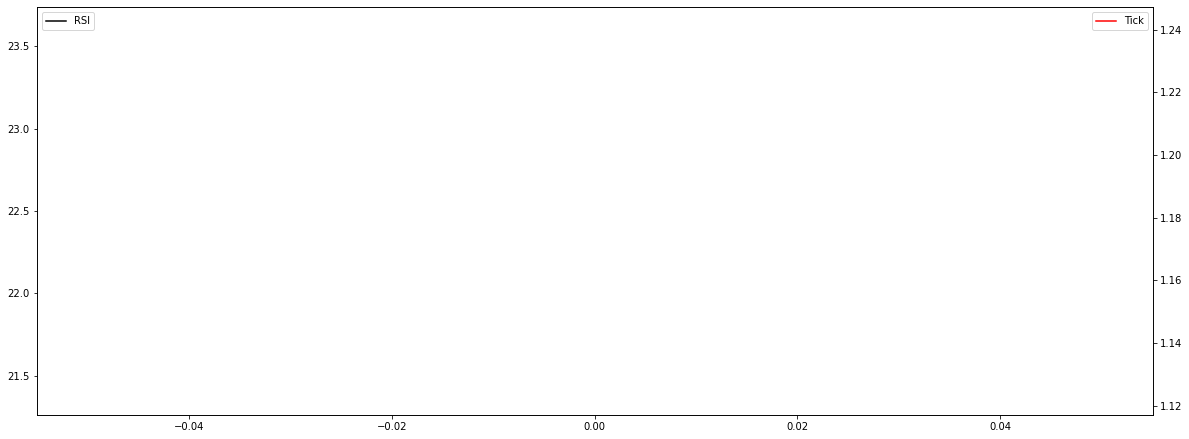

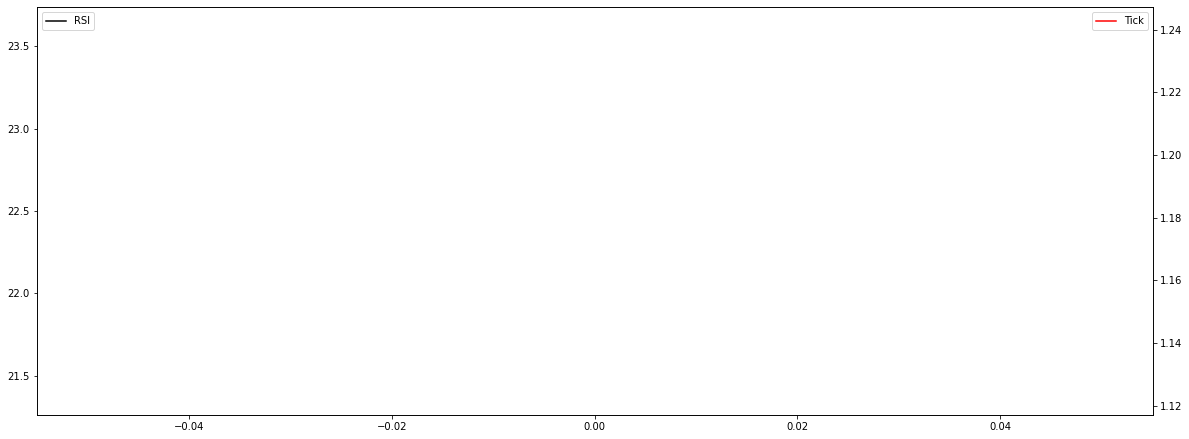

In [8]:
for i, resp in enumerate(response_stream): 
    if i == data['iter_max']:
        break
    if resp['type'] == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
        continue
    
    get_date_time(resp)
    get_prices(resp)
    
    display.clear_output(wait = True)
    
    if len(data['tick_list']) < data['rsi_len']:
        before_rsi_len()            
        print(f"Building RSI Tick list : {len(data['tick_list'])}")
        continue
    elif len(data['tick_list']) == data['rsi_len']:
        after_rsi_len()        
        
    print(i)
    print(data['RSI'][-1])
    
    
    temp.append(data['RSI'][-1])
    temp1.append(data['tick_price'])
    
    fig, ax1 = plt.subplots(1,1, figsize=(20,7.5))
    ax2 = ax1.twinx()

    ax1.plot(temp, 'k' ,label="RSI")
    ax2.plot(temp1, 'r' ,label="Tick")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    display.display(plt.gcf())
    display.clear_output(wait = True)